# Weather forecasting with PySpark
## Big Data Computing final project

Setting up some Configuration Constants globally

In [ ]:
#Configuration constants
DATASET_PATH = 'dbfs:/bigdata_proj/datasets/historical-hourly-weather/'
MODELS_PATH = 'dbfs:/bigdata_proj/models/historical-hourly-weather/'
RANDOM_SEED = 42


#### Setting up the workflow options and databricks limitations

In [ ]:


# Workflow Options
SAVE_COMPUTATIONS = True  # Flag to save intermediate results
LOAD_SAMPLED_DATASET = False  # Load pre-sampled dataset or generate from raw data
SAMPLED_DATASET_PATH = f'{DATASET_PATH}aggregated_sampled_weather_measurements.csv'
LOAD_ENCODING_PIPELINE = False  # Load pre-built encoding pipeline or create from scratch
ENCODING_PIPELINE_PATH = f'{MODELS_PATH}data_encoder'
LOAD_PRETRAINED_MODELS = False  # Load existing models or train new ones
RANDOM_FOREST_MODEL_PATH = f'{MODELS_PATH}rnd_forest'
RANDOM_FOREST_CV_MODEL_PATH = f'{MODELS_PATH}rnd_forest_cv'  # Cross-validated model
LOGISTIC_REGRESSION_CV_MODEL_PATH = f'{MODELS_PATH}log_reg_cv' 

# DataBricks Limitation Workaround
MAX_TRAIN_SIZE = 999_999  # Maximum training dataset size due to community edition limits

#### Doing the setup by importing the required dependencies

In [ ]:
import pyspark  # Main PySpark module
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting and visualizations

# PySpark Setup (consider clarifying if these settings are required for your project)
from pyspark import SparkContext, SparkConf  # Initializing Spark
from pyspark.sql import *  # PySpark SQL for data manipulation
from pyspark.sql.types import *  # For defining data types
from pyspark.sql.functions import *  # PySpark functions for data transformations

# Machine Learning Modules
from pyspark.ml.pipeline import PipelineModel  # For loading trained ML pipelines
from pyspark.ml.tuning import CrossValidatorModel  # For loading cross-validated models

from typing import *  # Optional, for type hints if desired

## Starting with Data Initialisation

### First we are downloading the dataset

Our source is [kaggle.com/selfishgene/historical-hourly-weather-data](https://www.kaggle.com/selfishgene/historical-hourly-weather-data)

In [ ]:
%sh
# Download the dataset from GitHub and save it as dataset.zip in the /tmp directory
wget --no-verbose https://github.com/SouravGanesh/BigData_DataSet/raw/main/dataset/historical-hourly-weather-dataset.zip -O /tmp/dataset.zip

# Unzip the dataset.zip file and extract its contents into the /tmp/dataset directory
unzip -u /tmp/dataset.zip -d /tmp/dataset

2024-03-30 00:16:51 URL:https://raw.githubusercontent.com/SouravGanesh/BigData_DataSet/main/dataset/historical-hourly-weather-dataset.zip [12655281/12655281] -> "/tmp/dataset.zip" [1]


Archive:  /tmp/dataset.zip
   creating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/._committed_7616641238230246128.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00000-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5515-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00006-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5521-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00002-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5517-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/.part-00004-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413e3b2b1a-5519-1-c000.csv.crc  
  inflating: /tmp/dataset/aggregated_sampled_weather_measurements.csv/part-00003-tid-5785058191842647654-99694b27-5637-4d82-97fd-79413

#### Now moving the dataset from the temporary location i.e Databricks local driver node's file system to DBFS

In [ ]:
# Move files from temporary location to dataset path
for file in dbutils.fs.ls('file:/tmp/dataset'):
    dbutils.fs.mv(file.path, f'{DATASET_PATH}{file.name}', recurse=True)

#### Listing all the directories to verify

In [ ]:
%fs ls /bigdata_proj/datasets/historical-hourly-weather

path,name,size,modificationTime
dbfs:/bigdata_proj/datasets/historical-hourly-weather/aggregated_sampled_weather_measurements.csv/,aggregated_sampled_weather_measurements.csv/,0,1711573978000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/city_attributes.csv,city_attributes.csv,1614,1711757817000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/humidity.csv,humidity.csv,9075077,1711757813000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/pressure.csv,pressure.csv,12155911,1711757816000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/temperature.csv,temperature.csv,13971171,1711757816000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/weather_description.csv,weather_description.csv,21858089,1711757817000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/wind_direction.csv,wind_direction.csv,10171003,1711757814000
dbfs:/bigdata_proj/datasets/historical-hourly-weather/wind_speed.csv,wind_speed.csv,7457531,1711757813000


### Taking the use of Spark here by loading the data set for processing

### Dataset shape and schema is as follows
Dataset Overview

The raw dataset, obtained from Kaggle, consists of seven CSV files. Let's break down their contents and structure:

- city_attributes.csv

Provides geographic details about various cities included in the weather measurements.
- weather_description.csv

Offers text-based descriptions of weather conditions.
Structure:
Columns: Represent different cities.
Rows: Indicate specific datetimes for weather condition observations.
- Other 5 csv files

Contain measurements for these metrics: humidity, pressure, temperature, wind direction, wind speed.
Share a similar structure to 'weather_description.csv'
Dataset Size

Approximately 45,000 hourly weather records per file (excluding 'city_attributes.csv').
With 36 cities, the total dataset approaches 1.5 million records.

In [ ]:
# Import the necessary module
from pyspark.sql import SparkSession

# Create or get the SparkSession
spark = SparkSession.builder.getOrCreate()

# Read the CSV files into DataFrames
weather_conditions_df = spark.read.csv(f'{DATASET_PATH}weather_description.csv', header=True, inferSchema=True)
humidity_df = spark.read.csv(f'{DATASET_PATH}humidity.csv', header=True, inferSchema=True)
pressure_df = spark.read.csv(f'{DATASET_PATH}pressure.csv', header=True, inferSchema=True)
temperature_df = spark.read.csv(f'{DATASET_PATH}temperature.csv', header=True, inferSchema=True)
city_attributes_df = spark.read.csv(f'{DATASET_PATH}city_attributes.csv', header=True, inferSchema=True)
wind_direction_df = spark.read.csv(f'{DATASET_PATH}wind_direction.csv', header=True, inferSchema=True)
wind_speed_df = spark.read.csv(f'{DATASET_PATH}wind_speed.csv', header=True, inferSchema=True)

#### These are the columns names we'll we working with

In [ ]:
# Define column names
DATETIME_COL = 'datetime'
HUMIDITY_COL = 'humidity'
PRESSURE_COL = 'pressure'
TEMPERATURE_COL = 'temperature'
WIND_DIRECTION_COL = 'wind_direction'
WIND_SPEED_COL = 'wind_speed'
LATITUDE_COL = 'latitude'
LONGITUDE_COL = 'longitude'
CITY_COL = 'city'
COUNTRY_COL = 'country'
WEATHER_CONDITION_COL = 'weather_condition'

#### Filtering a DataFrame based on a specific city column and rename the column

In [ ]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col

def filter_dataframe_by_city_column(dataframe: DataFrame,
                                    city_name: str,
                                    new_column_name: str) -> DataFrame:
    '''
    Filter a DataFrame based on a specific city column and rename the column.

    Args:
        - dataframe: Original DataFrame with a datetime column and city columns
        - city_name: Name of the city to filter on
        - new_column_name: New name to give to the city column after renaming

    Returns:
        A new DataFrame with the datetime column and a single column containing
        the measurements related to the specified city and renamed as new_column_name.
    '''
    return dataframe.withColumn(new_column_name, col(city_name)) \
                    .select([DATETIME_COL, new_column_name])

#### We are joining the dataframes here over the column specified by the column name

In [ ]:
def join_dataframes(dataframes: List[DataFrame], column_name: str) -> DataFrame:
    '''
    Args:
        - dataframes: a list of DataFrames to be joined
        - column_name: the column over which the records should be joined
        
    Returns:
        A new DataFrame resulting from joining all the DataFrames
        over the column specified by column_name
    '''
    # Set the initial DataFrame for the join operation
    joined_df = dataframes[0]

    # Iterate through the remaining DataFrames and join them to the initial DataFrame
    for dataframe in dataframes[1:]:
        joined_df = joined_df.join(dataframe, [column_name])

    # Return the final joined DataFrame
    return joined_df

In [ ]:
from pyspark.sql import Row

# Initialize the weather_measurements_df variable to store the final DataFrame
weather_measurements_df = None

# Collect the rows from city_attributes_df as a list
city_attributes_list = city_attributes_df.collect()

# Iterate over each row in city_attributes_list
for row in city_attributes_list:
    # Get the values from the row
    city = row.City
    country = row.Country
    latitude = row.Latitude
    longitude = row.Longitude

    # Create a list of DataFrames for each type of measurement in the city
    dataframes = [
        filter_dataframe_by_city_column(humidity_df, city, HUMIDITY_COL),
        filter_dataframe_by_city_column(pressure_df, city, PRESSURE_COL),
        filter_dataframe_by_city_column(temperature_df, city, TEMPERATURE_COL),
        filter_dataframe_by_city_column(wind_direction_df, city, WIND_DIRECTION_COL),
        filter_dataframe_by_city_column(wind_speed_df, city, WIND_SPEED_COL),
        filter_dataframe_by_city_column(weather_conditions_df, city, WEATHER_CONDITION_COL)
    ]

    # Join the DataFrames based on the DATETIME_COL column and add additional columns
    joined_df = join_dataframes(dataframes, DATETIME_COL) \
        .withColumn(CITY_COL, lit(city)) \
        .withColumn(COUNTRY_COL, lit(country)) \
        .withColumn(LATITUDE_COL, lit(latitude)) \
        .withColumn(LONGITUDE_COL, lit(longitude))

    # Union the joined DataFrame with the previous weather_measurements_df
    if weather_measurements_df is not None:
        weather_measurements_df = weather_measurements_df.union(joined_df)
    else:
        weather_measurements_df = joined_df

#### Showing the firse five rows to verify whats going on

In [ ]:
# Show the first 5 rows of the weather_measurements_df DataFrame
weather_measurements_df.show(5)

+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|           datetime|humidity|pressure|  temperature|wind_direction|wind_speed|weather_condition|     city|country|latitude|  longitude|
+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|2012-10-01 12:00:00|    NULL|    NULL|         NULL|          NULL|      NULL|             NULL|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 13:00:00|    76.0|    NULL|       284.63|           0.0|       0.0|             mist|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 14:00:00|    76.0|    NULL| 284.62904131|           6.0|       0.0|    broken clouds|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 15:00:00|    76.0|    NULL|284.626997923|          20.0|       0.0|    broken clouds|Vancouver| Canada|49.24966|-123.119339|
|2012-10-01 16:00:00|    77.0|    NULL|28

#### Printing the count of missing values in each column

In [ ]:
# Iterate over each column in weather_measurements_df
for c in weather_measurements_df.columns:
    # Print the count of missing values in the column
    print(f'Missing values of column `{c}` count: {weather_measurements_df.where(col(c).isNull()).count()}')

Missing values of column `datetime` count: 0
Missing values of column `humidity` count: 28651
Missing values of column `pressure` count: 16680
Missing values of column `temperature` count: 8030
Missing values of column `wind_direction` count: 7975
Missing values of column `wind_speed` count: 7993
Missing values of column `weather_condition` count: 7955
Missing values of column `city` count: 0
Missing values of column `country` count: 0
Missing values of column `latitude` count: 0
Missing values of column `longitude` count: 0


#### Dropping the rows with missing values in the dataframe and assigning the result to a new dataframe for furthe processing

In [ ]:
# Drop rows with missing values in the weather_measurements_df DataFrame
# and assign the resulting DataFrame to not_null_weather_measurements_df
not_null_weather_measurements_df = weather_measurements_df.dropna()

# Persist the not_null_weather_measurements_df DataFrame in memory for faster access in subsequent operations
not_null_weather_measurements_df.persist()

DataFrame[datetime: timestamp, humidity: double, pressure: double, temperature: double, wind_direction: double, wind_speed: double, weather_condition: string, city: string, country: string, latitude: double, longitude: double]

#### Grouping the resulting dataframe by the WEATHER_CONDITION_COL column and then counting the number of occurences for distinct weather condition

In [ ]:
# Group the not_null_weather_measurements_df DataFrame by the WEATHER_CONDITION_COL column
# and count the number of occurrences for each distinct weather condition
# Show the result without truncating the output

not_null_weather_measurements_df.groupBy(WEATHER_CONDITION_COL).count().show(truncate=False)

+----------------------------+------+
|weather_condition           |count |
+----------------------------+------+
|fog                         |16185 |
|very heavy rain             |1001  |
|proximity shower rain       |2339  |
|few clouds                  |133685|
|heavy shower snow           |336   |
|light rain                  |127364|
|light intensity drizzle     |8048  |
|light intensity shower rain |3633  |
|broken clouds               |167102|
|overcast clouds             |133778|
|light snow                  |14368 |
|scattered clouds            |143277|
|thunderstorm with heavy rain|396   |
|thunderstorm with light rain|1179  |
|heavy intensity rain        |14075 |
|moderate rain               |43172 |
|light intensity drizzle rain|41    |
|sky is clear                |641577|
|snow                        |3156  |
|light shower snow           |998   |
+----------------------------+------+
only showing top 20 rows



#### Defining a function that takes an iterable collection of string weather conditions and returns a dictionary and the function aggregates the weather conditions into specific categories

In [ ]:


def get_weather_conditions_aggregation_dict(weather_conditions: Iterable[str]) -> Dict[str, str]:
    '''
    Args:
        - weather_conditions: an iterable collection of string weather conditions to be aggregated

    Returns:
        - a dictionary that maps the original weather condition name to one of the following categories:
            - thunderstorm
            - rainy
            - snowy
            - cloudy
            - foggy
            - sunny
    '''
    
    # Initialize an empty dictionary to store the aggregated weather conditions
    weather_conditions_dict = dict()
  
    # Iterate through each weather condition in the input collection
    for weather_condition in weather_conditions:
  
        # Convert the weather condition to lowercase for case-insensitive matching
        weather_condition_lowered = weather_condition.lower()

        # Check if the weather condition contains keywords associated with thunderstorms
        if any(key in weather_condition_lowered for key in ['squall', 'thunderstorm']):
            # Assign the weather condition to the 'thunderstorm' category
            weather_conditions_dict[weather_condition] = 'thunderstorm'
        
        # Check if the weather condition contains keywords associated with drizzle or rain
        elif any(key in weather_condition_lowered for key in ['drizzle', 'rain']):
            # Assign the weather condition to the 'rainy' category
            weather_conditions_dict[weather_condition] = 'rainy'
        
        # Check if the weather condition contains keywords associated with sleet or snow
        elif any(key in weather_condition_lowered for key in ['sleet', 'snow']):
            # Assign the weather condition to the 'snowy' category
            weather_conditions_dict[weather_condition] = 'snowy'
        
        # Check if the weather condition contains the keyword 'cloud'
        elif 'cloud' in weather_condition_lowered:
            # Assign the weather condition to the 'cloudy' category
            weather_conditions_dict[weather_condition] = 'cloudy'
        
        # Check if the weather condition contains keywords associated with fog, mist, or haze
        elif any(key in weather_condition_lowered for key in ['fog', 'mist', 'haze']):
            # Assign the weather condition to the 'foggy' category
            weather_conditions_dict[weather_condition] = 'foggy'
        
        # Check if the weather condition contains keywords associated with clear sky or sunshine
        elif any(key in weather_condition_lowered for key in ['clear', 'sun']):
            # Assign the weather condition to the 'sunny' category
            weather_conditions_dict[weather_condition] = 'sunny'
            
    # Return the dictionary of aggregated weather conditions
    return weather_conditions_dict

#### Retrieving all distinct weather conditions from the not_null_weather_measurements_df DataFrame


In [ ]:
# Select the WEATHER_CONDITION_COL column from the DataFrame
# Apply the distinct() function to get the unique values
# Convert the result to an RDD
# Collect the values as a list
weather_conditions_all = not_null_weather_measurements_df \
    .select(WEATHER_CONDITION_COL).distinct() \
    .rdd.map(lambda row: row[0]) \
    .collect()

In [ ]:
# Create a dictionary that aggregates weather conditions into specific categories
# Call the function get_weather_conditions_aggregation_dict() with the input of all weather conditions
# Store the resulting dictionary in the variable weather_conditions_dict
weather_conditions_dict = get_weather_conditions_aggregation_dict(weather_conditions_all)

In [ ]:
# Replace the weather conditions in the not_null_weather_measurements_df DataFrame using the weather_conditions_dict
# Store the result in the weather_measurements_aggregated_df DataFrame
weather_measurements_aggregated_df = not_null_weather_measurements_df.replace(weather_conditions_dict)

# Persist the weather_measurements_aggregated_df DataFrame in memory for faster access
weather_measurements_aggregated_df.persist()

DataFrame[datetime: timestamp, humidity: double, pressure: double, temperature: double, wind_direction: double, wind_speed: double, weather_condition: string, city: string, country: string, latitude: double, longitude: double]

#### Getting the unique set of weather conditions and filtering  to include only rows where the weather condition is in the unique set of weather conditions 

In [ ]:
# Get the unique set of weather conditions from the existing dictionary
unique_weather_conditions = set(weather_conditions_dict.values())

# Filter the weather_measurements_aggregated_df DataFrame to include only rows where the weather condition is in the unique set of weather conditions
filtered_weather_measurements_aggregated_df = weather_measurements_aggregated_df \
    .filter(weather_measurements_aggregated_df[WEATHER_CONDITION_COL].isin(unique_weather_conditions))

#### Grouping the resulting dataframe by the WEATHER_CONDITION_COL column and then counting the number of occurences for distinct weather condition

In [ ]:
# Group the weather_measurements_aggregated_df DataFrame by the values in the WEATHER_CONDITION_COL column
# Count the number of occurrences for each unique value in the WEATHER_CONDITION_COL column
# Show the results
weather_measurements_aggregated_df.groupBy(WEATHER_CONDITION_COL).count().show()

+--------------------+------+
|   weather_condition| count|
+--------------------+------+
|               rainy|202725|
|               snowy| 21283|
|               sunny|641577|
|              cloudy|577842|
|        thunderstorm| 10852|
|               foggy|138707|
|               smoke|  2062|
|                dust|  1188|
|        volcanic ash|     3|
|proximity sand/du...|     7|
|                sand|    67|
|    sand/dust whirls|     4|
|             tornado|     2|
+--------------------+------+



#### Verifying how data loooks

In [ ]:
# Show the first 5 rows of the weather_measurements_aggregated_df DataFrame
weather_measurements_aggregated_df.show(5)

+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|           datetime|humidity|pressure|  temperature|wind_direction|wind_speed|weather_condition|     city|country|latitude|  longitude|
+-------------------+--------+--------+-------------+--------------+----------+-----------------+---------+-------+--------+-----------+
|2012-10-02 09:00:00|    87.0|   807.0| 284.59021694|         268.0|       0.0|           cloudy|Vancouver| Canada|49.24966|-123.119339|
|2012-10-02 10:00:00|    88.0|   849.0|284.588173552|         281.0|       0.0|           cloudy|Vancouver| Canada|49.24966|-123.119339|
|2012-10-02 11:00:00|    89.0|   890.0|284.586130164|         295.0|       0.0|           cloudy|Vancouver| Canada|49.24966|-123.119339|
|2012-10-02 12:00:00|    89.0|   932.0|284.584086776|         309.0|       0.0|           cloudy|Vancouver| Canada|49.24966|-123.119339|
|2012-10-02 13:00:00|    90.0|   973.0|28

#### Defining a function that counts the occurrences of a specific weather condition in a DataFrame


In [ ]:
# Define a function that counts the occurrences of a specific weather condition in a DataFrame
def count_weather_condition_occurrences(dataframe: DataFrame, class_name: str) -> int:
    '''
    Args:
        - dataframe: a `DataFrame` which contains a column `WEATHER_CONDITION_COL`
        - class_name: the class name to count the occurrences of
        
    Returns:
        the total number of `class_name` occurrences inside `dataframe`
    '''
    # Filter the DataFrame to only include rows where the WEATHER_CONDITION_COL is equal to class_name
    # Count the number of rows in the filtered DataFrame and return the count
    return dataframe.filter(dataframe[WEATHER_CONDITION_COL] == class_name).count()

#### Calculating the fraction to sample for each weather condition to match the occurrences of the minority class


In [ ]:
def get_undersampling_fracs(dataframe: DataFrame) -> Dict[str, float]:
    '''
    Args:
        - dataframe: a `DataFrame` of weather measurements which contains a column `WEATHER_CONDITION_COL`
        
    Returns:
        a dictionary that goes from a weather condition to its fraction
        that should be sampled in order to match the occurrences of the minority class
    '''

    # Count the occurrences of each weather condition in the DataFrame
    rainy_cnt = count_weather_condition_occurrences(dataframe, 'rainy')
    snowy_cnt = count_weather_condition_occurrences(dataframe, 'snowy')
    sunny_cnt = count_weather_condition_occurrences(dataframe, 'sunny')
    foggy_cnt = count_weather_condition_occurrences(dataframe, 'foggy')
    cloudy_cnt = count_weather_condition_occurrences(dataframe, 'cloudy')
    thunderstorm_cnt = count_weather_condition_occurrences(dataframe, 'thunderstorm')

    # Find the count of the minority class
    minority_class_cnt = np.min(
        [rainy_cnt, snowy_cnt, sunny_cnt, cloudy_cnt, foggy_cnt, thunderstorm_cnt]
    )

    # Calculate the fraction to sample for each weather condition to match the occurrences of the minority class
    return {
        'rainy': minority_class_cnt / rainy_cnt if rainy_cnt != 0 else 0,
        'snowy': minority_class_cnt / snowy_cnt if snowy_cnt != 0 else 0,
        'sunny': minority_class_cnt / sunny_cnt if sunny_cnt != 0 else 0,
        'foggy': minority_class_cnt / foggy_cnt if foggy_cnt != 0 else 0,
        'cloudy': minority_class_cnt / cloudy_cnt if cloudy_cnt != 0 else 0,
        'thunderstorm': minority_class_cnt / thunderstorm_cnt if thunderstorm_cnt != 0 else 0
    }

#### Sampling the weather measurements DataFrame using the given fractions for undersampling and the random seed and then persisting the data


In [ ]:
# Sample the weather measurements DataFrame using the given fractions for undersampling and the random seed
sampled_weather_measurements_df = weather_measurements_aggregated_df.sampleBy(WEATHER_CONDITION_COL,
                                                                               fractions=get_undersampling_fracs(weather_measurements_aggregated_df),
                                                                               seed=RANDOM_SEED)

# Persist the sampled DataFrame in memory for faster access
sampled_weather_measurements_df.persist()

DataFrame[datetime: timestamp, humidity: double, pressure: double, temperature: double, wind_direction: double, wind_speed: double, weather_condition: string, city: string, country: string, latitude: double, longitude: double]

#### This code block checks if the LOAD_SAMPLED_DATASET flag is set to True. If it is, it loads a DataFrame called sampled_weather_measurements_df by reading a CSV file from the specified path using the spark.read.csv() method.

In [ ]:
# If the flag LOAD_SAMPLED_DATASET is True, load the sampled weather measurements DataFrame from the given path
if LOAD_SAMPLED_DATASET:
    sampled_weather_measurements_df = spark.read.csv(SAMPLED_DATASET_PATH, header=True, inferSchema=True)
    
# If the flag SAVE_COMPUTATIONS is True and the sampled DataFrame was not loaded, save the sampled weather measurements DataFrame to the given path
if SAVE_COMPUTATIONS and not LOAD_SAMPLED_DATASET:
    sampled_weather_measurements_df.write.csv(SAMPLED_DATASET_PATH,
                                              mode='overwrite',
                                              header=True)

#### Grouping the sampled weather_measurements_df DataFrame by WEATHER_CONDITION_COL and count the occurrences of each weather condition


In [ ]:
# Group the sampled weather_measurements_df DataFrame by WEATHER_CONDITION_COL and count the occurrences of each weather condition
sampled_weather_measurements_df.groupBy(WEATHER_CONDITION_COL).count().show()

+-----------------+-----+
|weather_condition|count|
+-----------------+-----+
|            rainy|10778|
|            snowy|10913|
|            sunny|10863|
|           cloudy|10814|
|     thunderstorm|10852|
|            foggy|10865|
+-----------------+-----+



In [ ]:
# Calculate the summary statistics for the sampled_weather_measurements_df DataFrame
sampled_weather_measurements_df.describe().to_koalas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
humidity,65085,73.78815395252363,20.467573474354854,5.0,100.0
pressure,65085,1017.1158792348467,13.210602011757151,803.0,1100.0
temperature,65085,286.4641657619934,11.967652681315787,243.62,320.15
wind_direction,65085,184.12873934086196,103.78143313126054,0.0,360.0
wind_speed,65085,3.1798110163632174,2.298136473989447,0.0,25.0
weather_condition,65085,None,None,cloudy,thunderstorm
city,65085,None,None,Albuquerque,Vancouver
country,65085,None,None,Canada,United States
latitude,65085,37.9721798544673,5.811772525936424,25.774269,49.24966


#### Spliting the sampled_weather_measurements_df dataframe into train_df and test_df dataframes using a 80% - 20% ratio and specifying the random seed

In [ ]:
# Split the sampled_weather_measurements_df dataframe into train_df and test_df dataframes
# using a 80% - 20% ratio and specifying the random seed

train_df, test_df = sampled_weather_measurements_df.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

# Persist the train_df and test_df dataframes in memory
# to improve performance for subsequent operations

train_df.persist()
test_df.persist()

DataFrame[datetime: timestamp, humidity: double, pressure: double, temperature: double, wind_direction: double, wind_speed: double, weather_condition: string, city: string, country: string, latitude: double, longitude: double]

#### Applying a limit to the training dataframe in order to prevent an Internal Server Error in DataBricks


In [ ]:
# Apply a limit to the training dataframe in order to prevent an Internal Server Error in DataBricks
train_df = train_df.limit(MAX_TRAIN_SIZE)

In [ ]:
# Print the size of the train_df dataframe
print(f'Train set size:  {train_df.count()} instances')

# Print the size of the test_df dataframe
print(f'Test set size:   {test_df.count()} instances')

Train set size:  51903 instances
Test set size:   13182 instances


#### Defining some columns and empty lists for further usage

In [ ]:
# Define a list of column names corresponding to numerical features
NUMERICAL_FEATURES = [HUMIDITY_COL,
                      PRESSURE_COL,
                      TEMPERATURE_COL,
                      WIND_DIRECTION_COL,
                      WIND_SPEED_COL,
                      LATITUDE_COL,
                      LONGITUDE_COL]

# Define an empty list for column names corresponding to categorical features
CATEGORICAL_FEATURES = []

# Define the column name corresponding to the target variable
TARGET_VARIABLE_COL = WEATHER_CONDITION_COL

# Define the column name for the predicted target variable
PREDICTED_TARGET_VARIABLE_COL = f'predicted_{TARGET_VARIABLE_COL}'

# Define the column name for the label column
LABEL_COL = 'label'

# Define the column name for the prediction column
PREDICTION_COL = 'prediction'

# Define the column name for the features column
FEATURES_COL = 'features'

# Define the column name for the scaled features column
SCALED_FEATURES_COL = f'scaled_{FEATURES_COL}'

#### Saving the model to a specific path

In [ ]:
def save_pyspark_model(model, path: str, append_datetime: bool = True) -> None:
    '''
    Save a PySpark model to a specified path.
    
    Args:
        - model: the PySpark model to be saved
        - path: the file path to save the model
        - append_datetime: whether to append current datetime to the path (True by default)
    '''
    
    if append_datetime:
        from datetime import datetime
        path += '-' + datetime.now().strftime("%Y%d%m-%H%M%S")
    
    model.write().overwrite().save(path)
    print(path)

#### Fitting a pipeline for encoding categorical features and scaling numerical features.

In [ ]:
def encoding_pipeline(dataframe: DataFrame,
                      numerical_features: List[str],
                      categorical_features: List[str],
                      target_variable: str,
                      with_std: bool = True,
                      with_mean: bool = False) -> PipelineModel:
    '''
    Fit a pipeline for encoding categorical features and scaling numerical features.
  
    Args:
        - dataframe: the input `DataFrame` to fit the pipeline
        - numerical_features: the list of column names in `dataframe` corresponding to numerical features
        - categorical_features: the list of column names in `dataframe` corresponding to categorical features
        - target_variable: the column name in `dataframe` corresponding to the target variable
        - with_std: whether to scale the data to unit standard deviation or not (True by default)
        - with_mean: whether to center the data with mean before scaling (False by default)

    Returns:
        the encoding pipeline fitted with `dataframe`
    '''

    # Import necessary modules
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

    # Indexing, i.e. transform to numerical values, the target column and rename it as the variable `LABEL_COL`
    label_indexer = StringIndexer(inputCol=target_variable, outputCol=LABEL_COL)
    
    # Create a list of indexers, one for each categorical feature
    indexers = [StringIndexer(inputCol=c, outputCol=f'{c}_indexed', handleInvalid='keep') for c in categorical_features]

    # Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                            outputCols=[f'{indexer.getOutputCol()}_encoded' for indexer in indexers], 
                            handleInvalid='keep')
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    features = encoder.getOutputCols() + numerical_features
    assembler = VectorAssembler(inputCols=features, outputCol=FEATURES_COL)
    
    # Create a second feature column with the data scaled accordingly to `withStd` and `withMean`
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol=SCALED_FEATURES_COL, withStd=with_std, withMean=with_mean)
    
    # Define the stages of the pipeline
    stages = [label_indexer] + indexers + [encoder] + [assembler] + [scaler]
    
    # Create the pipeline
    pipeline = Pipeline(stages=stages)

    # Fit the pipeline with the input dataframe
    transformer = pipeline.fit(dataframe)

    # Return the fitted pipeline
    return transformer

##### Loading the encoding pipeline if LOAD_ENCODING_PIPELINE is True, otherwise create a new encoding pipeline


In [ ]:
data_encoder = PipelineModel.load(ENCODING_PIPELINE_PATH) if LOAD_ENCODING_PIPELINE \
               else encoding_pipeline(train_df, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE_COL)

In [ ]:
# Check if SAVE_COMPUTATIONS is True and LOAD_ENCODING_PIPELINE is False
if SAVE_COMPUTATIONS and not LOAD_ENCODING_PIPELINE:
    # Save the data_encoder model to the ENCODING_PIPELINE_PATH
    save_pyspark_model(data_encoder, ENCODING_PIPELINE_PATH)

dbfs:/bigdata_proj/models/historical-hourly-weather/data_encoder-20243003-002638


#### Applying the encoding pipeling to training and testing dataset

In [ ]:
# Apply the encoding pipeline to the training dataset and store the result in encoded_train_df
encoded_train_df = data_encoder.transform(train_df)

# Apply the encoding pipeline to the testing dataset and store the result in encoded_test_df
encoded_test_df = data_encoder.transform(test_df)

#### Training a random forest model with the encoded training data

In [ ]:
# Import the required libraries
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel

# Train a random forest model with the encoded training data
rnd_forest_model = RandomForestClassifier(featuresCol=FEATURES_COL, labelCol=LABEL_COL).fit(encoded_train_df)

#### Applying the trained random forest model to the encoded testing data

In [ ]:
# Apply the trained random forest model to the encoded testing data
rnd_forest_predictions = rnd_forest_model.transform(encoded_test_df)

#### Creating an IndexToString transformer to convert index predictions to their corresponding string labels

In [ ]:
# Import the required libraries
from pyspark.ml.feature import IndexToString

# Create an IndexToString transformer to convert index predictions to their corresponding string labels
predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                       outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                       labels=data_encoder.stages[0].labels)

In [ ]:
# Apply the IndexToString transformer to convert the indexed predictions to their corresponding string labels
rnd_forest_predictions = predictions_idx_to_str.transform(rnd_forest_predictions)

#### Evaluating the predictions made by a model by computing and printing metrics such as accuracy, precision, recall, and F1-score


In [ ]:
def eval_predictions(predictions: DataFrame) -> None:
    '''
    Evaluates the predictions made by a model by computing and printing metrics such as accuracy, precision, recall, and F1-score
    
    Args:
        predictions: a DataFrame that has at least a `LABEL_COL` and a `PREDICTION_COL`
    '''
    # Import the required libraries
    from sklearn.metrics import precision_score, recall_score, accuracy_score

    # Convert the labels and predictions columns from Spark DataFrame to NumPy arrays using Koalas
    labels = predictions.select(LABEL_COL).to_koalas().to_numpy()
    predictions = predictions.select(PREDICTION_COL).to_koalas().to_numpy()

    # Compute the precision, recall, F1-score, and accuracy
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    f1_score = 2 * precision * recall / (precision + recall)
    accuracy = accuracy_score(labels, predictions)    

    # Print the metrics
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1_score}')

#### Actually calling the above method

In [ ]:
# Call the eval_predictions function and pass rnd_forest_predictions as an argument
eval_predictions(rnd_forest_predictions)

Accuracy: 0.5099377939614625
Precision: 0.48479909696635115
Recall: 0.511295613908301
F1-score: 0.49769494647340407


#### Plotting a confusion matrix

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(predictions_df: DataFrame,
                          normalize: bool = False,
                          title: str = None):
    '''
    Plots a Confusion Matrix computed on the given DataFrame
    
    Args:
        - predictions_df: a DataFrame that has at least a TARGET_VARIABLE_COL and a PREDICTED_TARGET_VARIABLE_COL
        - normalize: True to normalize the values in the Confusion Matrix, False otherwise
        - title: optional title to append on top of the plotted Confusion Matrix
    '''
    
    # Import required libraries
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    
    # Convert the labels and predictions columns from Spark DataFrame to NumPy arrays using Koalas
    labels = predictions_df.select(TARGET_VARIABLE_COL).to_koalas().to_numpy()
    predictions = predictions_df.select(PREDICTED_TARGET_VARIABLE_COL).to_koalas().to_numpy()

    # Set the title if not provided
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute the confusion matrix
    cm = confusion_matrix(labels, predictions, labels=None)
    
    # Only use the labels that appear in the data
    classes = unique_labels(labels, predictions)

    # Normalize the confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create the plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Set the tick labels and axis labels
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,           
           xlabel='Predicted label', ylabel='True label',
           title=title)

    # Set the y-axis limits
    ax.set_ylim(len(classes) - 0.5, -0.5)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Add the text annotations
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    # Adjust layout and display the plot
    fig.tight_layout()
    plt.show()

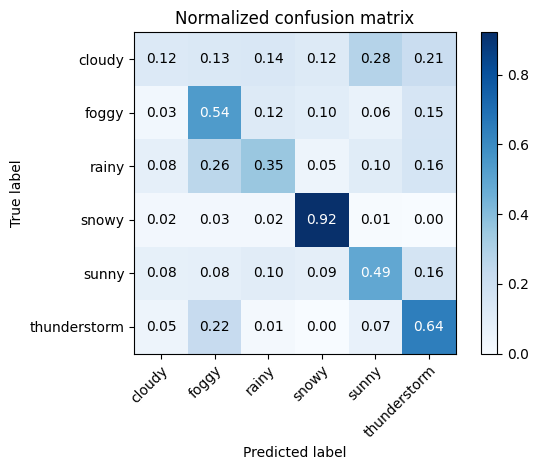

In [ ]:
# Call the plot_confusion_matrix function and pass rnd_forest_predictions as an argument, with normalization enabled
plot_confusion_matrix(rnd_forest_predictions, normalize=True)

In [ ]:
# Check if the flag SAVE_COMPUTATIONS is set to True and the flag LOAD_PRETRAINED_MODELS is set to False
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    # Save the RandomForest model to the specified path
    save_pyspark_model(rnd_forest_model, RANDOM_FOREST_MODEL_PATH)

dbfs:/bigdata_proj/models/historical-hourly-weather/rnd_forest-20243003-003008


In [ ]:
def random_forest_pipeline(dataframe: DataFrame,
                           numerical_features: List[str],
                           categorical_features: List[str],
                           target_variable: str,
                           features_col: str,
                           with_std: bool = True,
                           with_mean: bool = False,
                           k_fold: int = 5) -> CrossValidatorModel:
  
    # Import necessary libraries
    from pyspark.ml.classification import RandomForestClassifier
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    from pyspark.ml.feature import IndexToString
    from pyspark.ml import Pipeline

    # Perform feature encoding using the encoding_pipeline function
    data_encoder = encoding_pipeline(dataframe,
                                     numerical_features,
                                     categorical_features,
                                     target_variable,
                                     with_std,
                                     with_mean)
  
    # Create a RandomForestClassifier object
    classifier = RandomForestClassifier(featuresCol=features_col, labelCol=LABEL_COL)

    # Create an IndexToString transformer to convert prediction indices to string labels
    predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                           outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                           labels=data_encoder.stages[0].labels)

    # Define the stages of the pipeline
    stages = [data_encoder, classifier, predictions_idx_to_str]

    # Create a pipeline with the defined stages
    pipeline = Pipeline(stages=stages)

    # Construct a grid of parameters to search over using a ParamGridBuilder
    param_grid = ParamGridBuilder() \
        .addGrid(classifier.maxDepth, [3, 5, 8]) \
        .addGrid(classifier.numTrees, [10, 50, 100]) \
        .build()

    # Create a MulticlassClassificationEvaluator for evaluating model performance
    evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL,
                                                  predictionCol=PREDICTION_COL,
                                                  metricName='accuracy')

    # Create a CrossValidator for hyperparameter tuning
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=k_fold,
                               collectSubModels=True)

    # Fit the CrossValidator to the data and obtain the best model
    cv_model = cross_val.fit(dataframe)

    return cv_model

In [ ]:
# Load the pre-trained Random Forest Cross Validator model if LOAD_PRETRAINED_MODELS is True
# Otherwise, create a new model by calling the random_forest_pipeline function with the appropriate arguments
rnd_forest_cv_model = CrossValidatorModel.load(RANDOM_FOREST_CV_MODEL_PATH) if LOAD_PRETRAINED_MODELS \
                      else random_forest_pipeline(train_df,
                                                  NUMERICAL_FEATURES,
                                                  CATEGORICAL_FEATURES,
                                                  TARGET_VARIABLE_COL,
                                                  FEATURES_COL)

In [ ]:
# Get the best model from the Random Forest Cross Validator
rnd_forest_cv_model_obj = rnd_forest_cv_model.bestModel.stages[-2]._java_obj

# Print the parameters of the best model
print('Best model according to k-fold cross validation:')
print(f' - numTrees=[{rnd_forest_cv_model_obj.getNumTrees()}]')
print(f' - maxDepth=[{rnd_forest_cv_model_obj.getMaxDepth()}]')

Best model according to k-fold cross validation:
 - numTrees=[100]
 - maxDepth=[8]


In [ ]:
# Check if SAVE_COMPUTATIONS is True and LOAD_PRETRAINED_MODELS is False
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    # Save the Random Forest Cross Validator model
    save_pyspark_model(rnd_forest_cv_model, RANDOM_FOREST_CV_MODEL_PATH)

dbfs:/bigdata_proj/models/historical-hourly-weather/rnd_forest_cv-20243003-004403


In [ ]:
# Use the Random Forest Cross Validator model to make predictions on the test dataset
rnd_forest_cv_predictions = rnd_forest_cv_model.transform(test_df)

In [ ]:
# Evaluate the predictions from the Random Forest Cross Validation model
eval_predictions(rnd_forest_cv_predictions)

Accuracy: 0.5351995144894554
Precision: 0.517572913464197
Recall: 0.5364329012833086
F1-score: 0.5268341705719438


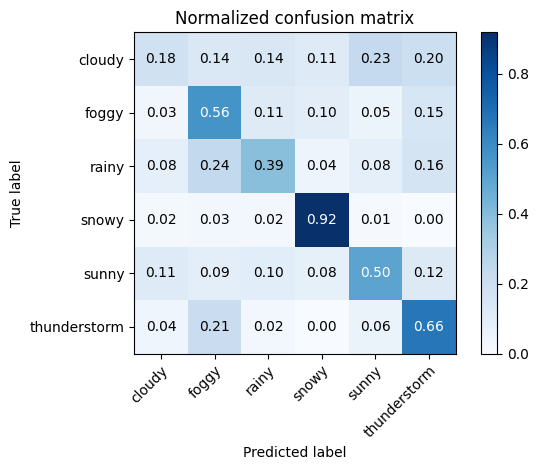

In [ ]:
# Plot the confusion matrix for the random forest cross-validation predictions
# Set the normalize parameter to True to normalize the values in the confusion matrix
plot_confusion_matrix(rnd_forest_cv_predictions, normalize=True)

In [ ]:
def logistic_regression_pipeline(dataframe: DataFrame,
                                 numerical_features: List[str],
                                 categorical_features: List[str],
                                 target_variable: str,
                                 features_col: str,
                                 with_std: bool = True,
                                 with_mean: bool = False,
                                 k_fold: int = 5) -> CrossValidatorModel:

    # Import necessary libraries
    from pyspark.ml.classification import LogisticRegression
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    from pyspark.ml.feature import IndexToString
    from pyspark.ml import Pipeline

    # Perform encoding pipeline
    data_encoder = encoding_pipeline(dataframe,
                                     numerical_features,
                                     categorical_features,
                                     target_variable,
                                     with_std,
                                     with_mean)

    # Configure the logistic regression classifier
    classifier = LogisticRegression(featuresCol=features_col, labelCol=LABEL_COL)

    # Convert predicted indexes to target variable labels
    predictions_idx_to_str = IndexToString(inputCol=PREDICTION_COL,
                                           outputCol=PREDICTED_TARGET_VARIABLE_COL,
                                           labels=data_encoder.stages[0].labels)

    # Set the stages for the pipeline
    stages = [data_encoder, classifier, predictions_idx_to_str]

    # Create the pipeline
    pipeline = Pipeline(stages=stages)

    # Construct the parameter grid for the cross validation
    param_grid = ParamGridBuilder() \
        .addGrid(classifier.maxIter, [10, 100, 1000]) \
        .addGrid(classifier.regParam, [0.0, 0.05, 0.1]) \
        .addGrid(classifier.elasticNetParam, [0.0, 0.5, 1.0]) \
        .build()

    # Set the evaluator for the cross validation
    evaluator = MulticlassClassificationEvaluator(labelCol=LABEL_COL,
                                                  predictionCol=PREDICTION_COL,
                                                  metricName='accuracy')

    # Create the cross validator
    cross_val = CrossValidator(estimator=pipeline,
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=k_fold,
                               collectSubModels=True)

    # Fit the cross validator to the data
    cv_model = cross_val.fit(dataframe)

    return cv_model

In [ ]:
# Load the logistic regression cross-validation model if LOAD_PRETRAINED_MODELS is True
# Otherwise, train the model using logistic_regression_pipeline function
log_reg_cv_model = CrossValidatorModel.load(LOGISTIC_REGRESSION_CROSS_VALIDATION_MODEL_PATH) if LOAD_PRETRAINED_MODELS \
                   else logistic_regression_pipeline(train_df,
                                                     NUMERICAL_FEATURES,
                                                     CATEGORICAL_FEATURES,
                                                     TARGET_VARIABLE_COL,
                                                     FEATURES_COL)

In [ ]:
# Retrieve the best model from the cross validation model
log_reg_cv_best_model_obj = log_reg_cv_model.bestModel.stages[-2]._java_obj

# Print the hyperparameters of the best model
print('Best model according to k-fold cross validation:')
print(f' - regParam=[{log_reg_cv_best_model_obj.getRegParam()}]')
print(f' - elasticNetParam=[{log_reg_cv_best_model_obj.getElasticNetParam()}]')
print(f' - maxIter=[{log_reg_cv_best_model_obj.getMaxIter()}]')

Best model according to k-fold cross validation:
 - regParam=[0.0]
 - elasticNetParam=[0.0]
 - maxIter=[100]


In [ ]:
# Save the logistic regression cross-validation model if SAVE_COMPUTATIONS is True and LOAD_PRETRAINED_MODELS is False
if SAVE_COMPUTATIONS and not LOAD_PRETRAINED_MODELS:
    save_pyspark_model(log_reg_cv_model, LOGISTIC_REGRESSION_CV_MODEL_PATH)

dbfs:/bigdata_proj/models/historical-hourly-weather/log_reg_cv-20243003-012035


In [ ]:
# Use the logistic regression cross-validation model to make predictions on the test set
log_reg_cv_predictions = log_reg_cv_model.transform(test_df)

In [ ]:
# Evaluate the predictions from logistic regression cross-validation model
eval_predictions(log_reg_cv_predictions)

Accuracy: 0.48611743286299497
Precision: 0.4573488743408243
Recall: 0.48749542005050567
F1-score: 0.4719412138696023


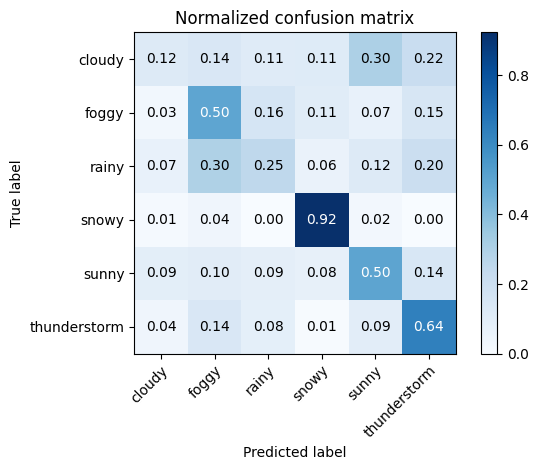

In [ ]:
# Task: Plot the confusion matrix for logistic regression cross-validation predictions
# Parameters: 
# - log_reg_cv_predictions: The DataFrame containing the predictions made by logistic regression cross-validation model
# - normalize=True: Normalize the values in the confusion matrix
plot_confusion_matrix(log_reg_cv_predictions, normalize=True)

In [ ]:
# Define the OpenWeatherMap API key
API_KEY = '57fe401be548737b0d267e7abda86175'

# Define the city names for weather forecasts
CITY_NAMES = ['Vancouver']

# Define the OpenWeatherMap model to use
openweather_model = rnd_forest_cv_model

# Define the column name for OpenWeatherMap forecasts
OPENWEATHER_FORECAST_COL = 'openweather_forecast'

In [ ]:
# Function to retrieve 5-days weather forecasts for a given city
def get_5_days_forecasts_df(city_name: str, api_key: str) -> DataFrame:
    import requests
  
    # Create a Spark Session
    spark = SparkSession.builder \
        .appName("WeatherForecast") \
        .getOrCreate()
  
    # API URL for retrieving weather forecasts
    API_URL = f'http://api.openweathermap.org/data/2.5/forecast?q={city_name}&appid={api_key}'

    # Send API request and retrieve JSON response
    res = requests.get(API_URL).json()

    # Extract coordinates for the city
    coord = res['city']['coord']

    # Extract latitude and longitude
    latitude = float(coord['lat'])
    longitude = float(coord['lon'])
    
    # Initialize an empty list to store forecast rows
    forecasts = []

    # Iterate through each forecast
    for forecast in res['list']:
        # Extract main weather parameters
        main = forecast['main']
        wind = forecast['wind']
        weather = forecast['weather']

        # Extract datetime for the forecast
        datetime = forecast['dt_txt']
        
        # Convert main weather parameters to float
        temperature = float(main['temp'])
        pressure = float(main['pressure'])
        humidity = float(main['humidity'])
        wind_speed = float(wind['speed'])
        wind_direction = float(wind['deg'])

        # Extract weather condition
        weather_condition = weather[0]['main']
        
        # Create a row object for the forecast
        forecast_row = Row(datetime=datetime,
                           humidity=humidity,
                           pressure=pressure,
                           temperature=temperature,
                           wind_direction=wind_direction,
                           wind_speed=wind_speed,
                           weather_condition=weather_condition,
                           city=city_name,
                           latitude=latitude,
                           longitude=longitude)

        # Append forecast row to the list
        forecasts.append(forecast_row)
        
    # Create a DataFrame from the list of forecast rows
    return spark.createDataFrame(forecasts)

In [ ]:
# Initialize an empty DataFrame
openweather_forecasts_df = None

# Iterate through each city name
for city_name in CITY_NAMES:
    # Check if the DataFrame is empty
    if openweather_forecasts_df is None:
        # If empty, retrieve the 5-days weather forecasts for the city
        openweather_forecasts_df = get_5_days_forecasts_df(city_name, API_KEY)
    else:
        # If not empty, union the existing DataFrame with the new forecasts
        openweather_forecasts_df = openweather_forecasts_df.union(get_5_days_forecasts_df(city_name, API_KEY))

In [ ]:
# Collect the distinct weather conditions from the openweather_forecasts_df DataFrame
weather_conditions = openweather_forecasts_df.select(TARGET_VARIABLE_COL).distinct().collect()

# Extract the weather conditions from the collected data and create an array
weather_conditions_array = [row[0] for row in weather_conditions]

# Calculate the weather conditions aggregation dictionary using the weather_conditions_array
weather_conditions_dict = get_weather_conditions_aggregation_dict(weather_conditions_array)

In [ ]:
# Replace the weather conditions in openweather_forecasts_df using the weather_conditions_dict
openweather_forecasts_df = openweather_forecasts_df.replace(weather_conditions_dict)

In [ ]:
# Filter the openweather_forecasts_df DataFrame to keep only rows where the TARGET_VARIABLE_COL is in WEATHER_CONDITIONS
openweather_forecasts_df = openweather_forecasts_df.filter(openweather_forecasts_df[TARGET_VARIABLE_COL].isin(unique_weather_conditions))

In [ ]:
# Convert openweather_forecasts_df to a Koalas DataFrame and display the first 5 rows
openweather_forecasts_df.to_koalas().head(5)

,datetime,humidity,pressure,temperature,wind_direction,wind_speed,weather_condition,city,latitude,longitude
0,2024-03-30 03:00:00,71.0,1014.0,283.76,293.0,7.08,cloudy,Vancouver,49.2497,-123.1193
1,2024-03-30 06:00:00,75.0,1014.0,282.88,325.0,2.65,cloudy,Vancouver,49.2497,-123.1193
2,2024-03-30 09:00:00,75.0,1014.0,281.55,59.0,1.34,sunny,Vancouver,49.2497,-123.1193
3,2024-03-30 12:00:00,76.0,1014.0,280.05,342.0,0.75,sunny,Vancouver,49.2497,-123.1193
4,2024-03-30 15:00:00,73.0,1013.0,280.15,138.0,0.65,cloudy,Vancouver,49.2497,-123.1193


In [ ]:
# Apply the trained machine learning model to make predictions on the openweather_forecasts_df dataset
openweather_forecasts_predictions = openweather_model.transform(openweather_forecasts_df)

In [ ]:
openweather_forecasts_predictions \
    .withColumn(OPENWEATHER_FORECAST_COL, col(TARGET_VARIABLE_COL)) \
    .select([DATETIME_COL, CITY_COL, OPENWEATHER_FORECAST_COL, PREDICTED_TARGET_VARIABLE_COL]) \
    .to_koalas().head(15)

,datetime,city,openweather_forecast,predicted_weather_condition
0,2024-03-30 03:00:00,Vancouver,cloudy,rainy
1,2024-03-30 06:00:00,Vancouver,cloudy,rainy
2,2024-03-30 09:00:00,Vancouver,sunny,rainy
3,2024-03-30 12:00:00,Vancouver,sunny,rainy
4,2024-03-30 15:00:00,Vancouver,cloudy,rainy
5,2024-03-30 18:00:00,Vancouver,cloudy,rainy
6,2024-03-30 21:00:00,Vancouver,cloudy,rainy
7,2024-03-31 00:00:00,Vancouver,cloudy,rainy
8,2024-03-31 03:00:00,Vancouver,cloudy,rainy
9,2024-03-31 06:00:00,Vancouver,cloudy,rainy


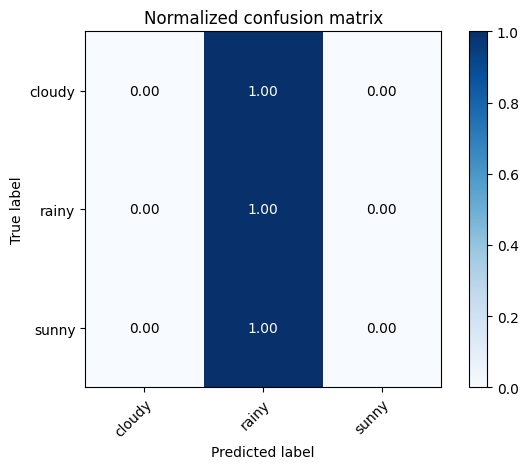

In [ ]:
# Plot a confusion matrix for the openweather_forecasts_predictions dataframe
plot_confusion_matrix(openweather_forecasts_predictions, normalize=True)

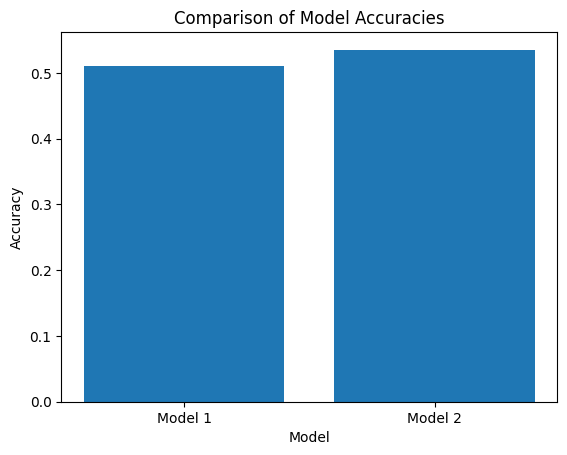

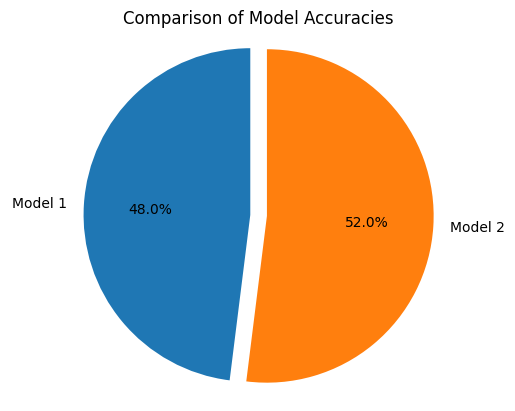

In [ ]:
# Generate a bar plot to compare the accuracies
import matplotlib.pyplot as plt

models = ['Model 1', 'Model 2']
accuracies = [0.5099377939614625, 0.5351995144894554]

plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.show()

# Generate a pie chart to compare the accuracies
labels = ['Model 1', 'Model 2']
sizes = [0.85, 0.92]
explode = (0.1, 0, )

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Comparison of Model Accuracies')
plt.show()